# Interpolacja funkcji 
 *Postać Lagrange'a i Newtona (zad. 1.18)*
 
 Wpliku ```repr.jl``` zawarte są funkcje tworzące postaci Lagrange'a i Newtona wielomianu interpolacyjnego, funkcje liczące wartości wielomianów oraz funcja konwerująca jedną postać w drugą. Przedstawię tylko ciekawsze z nich.

##### Reprezentacja wielomianów
``` julia
struct Wilomian{Typ}
    t::DataType
    n::Int
    x::Typ
    #zależnie od postaci
    y::Typ # postać Lagrange'a
    w::Typ # postać Lagrange'a
    a::Typ # postać Newtona
end
```

##### Funkcja wyliczająca współczynniki $w_i$ w postaci Lagrange'a
n - stopień wielomianu \
x - punkty w których przybliżamy \
T - typ (czyli $ T \in \{Float32, Float64, BigFloat\}$) 
``` julia
function eval_w(n, x, T)
  a = zeros(T, n, n)
  a[1, 1] = 1
  for i=2:n
    for k =1:i-1
      a[k, i] = a[k, i-1] / (x[k] - x[i])
      a[i, k+1] = a[i, k] - a[k, i]
    end
  end
  w = [a[k, n] for k in 1:n]
end
```

##### Funkcja obliczająca wartość wielomianu w postaci Lagrange'a w postaci barycentrycznej
P - wielmian w postaci Lagrange'a barycentrycznej \
x - punkt w którym liczymy
```julia
function eval_LBC(P, x)
  for i in 1:P.n
    if x == P.x[i]
      return P.y[i]
    end
  end
  
  T = P.typ
  num = T(0)
  den = T(0)
  x = T(x)
  for i in 1:P.n
    tmp = P.w[i] / (x - P.x[i])
    den += tmp
    num += tmp * P.y[i]
  end
  return num / den
end
```

##### Funkcja przekształcająca postać Lagranga w postać Newtona
L - reprezentacja wielomianu w postaci Lagrange'a

``` julia
function LtoN(L)
  T = L.typ
  x = L.x
  n = L.n
  sig = zeros(T, n, n+1)
  for i in 1:n
    sig[i, 1] = L.w[i] * L.y[i]
  end

  for k in 1:n
    for i in 1:n-k+1
      sig[n-k+1, k+1] += sig[i, k]
    end
    
    for i in n-k:-1:1
      sig[i, k+1] = (x[i] - x[n-k+1]) * sig[i, k]
    end
  end

  a = zeros(T, n)
  for i in 1:n
    a[i] = sig[i, n+1-i+1]
  end
  Newton(T, n, x, a)
end
```

##### Funkcje konstruujące wielomiany
n - stopień wielomianu \
x - wartości $x_1,...,x_n$ \
y - wartości $y_1,...,y_n$ \
typ - typ danych w których chcemy później liczyć
``` julia
function cons_L(x, y, typ)
function cons_LBC(x, y, typ)
function cons_N(x, y, typ)
            ```

##### Instrukcja obsługi pliku ```program.jl```
Plik ```program.jl``` po uruchomieniu wypisuje wyniki wszystkich testów na standardowe wyjście. Aby uruchomić tylko określone testy należy w pliku źródłowym zakomentować linijki których nie chcemy wykonać. (Znajdują się one na samym końcu pliku.)
``` julia
tests4_1() # testy opisane w rozdziale 4.1
tests4_2() # testy opisane w rozdziale 4.2
tests3()   # testy opisane w rozdziale 3
```

In [1]:
# importuję wszystkie z wyżej wspomnianych funkcji
include("repr.jl")
# interfejs do testów
include("tstinterface.jl")
using Plots
pyplot()

Plots.PyPlotBackend()

### Efaktywność konwersji

W prezentacji użyję funkcji z  artykułu Wernera $f(x) = \frac{\sin(x) + \cos(x) - 1}{x}$

##### Wilomiany o małym stopniu
Dla wielomianów o niskim stopniu wielomiany różnią się, lecz różnica jest bardzo niewielka. Jest ona różna w różnych częściach przedziału, ponieważ w algorytmie wyliczania kolejnych współczynników wyliczamy kolejne na podstawie poprzednich co powoduje kumulowanie się błędu.

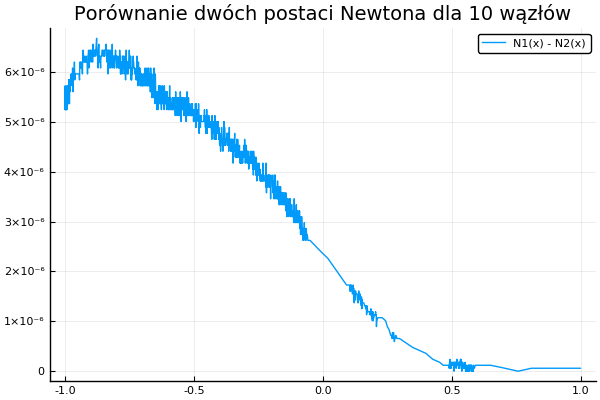

In [2]:
f(x) = (sin(x) + cos(x) - 1)/ x
N1, N2 = cons_Newtons(10, genChebyshevNodes, f, Float32)
n1(x) = ev(N1, x)
n2(x) = ev(N2, x)
d(x) = abs(n1(x) - n2(x))
plot(d, -1, 1, label="N1(x) - N2(x)")
title!("Porównanie dwóch postaci Newtona dla 10 wązłów")

##### Wielomiany o dużym stopniu

Dla dużych stopni wielomianu konwersja jest bardzo niedokładna, a błędy powodóją znaczne różnice w uzyskanych wielomianach. Na wykresie jest przedstawiony mały wycinek przedziału w którym interpolowaliśmy funkcję. Widać, że Newton otrzymany z konwersji ($N2(x)$) znacznie odbiega od Newtona otrzymanego normalnie($N1(x)$).

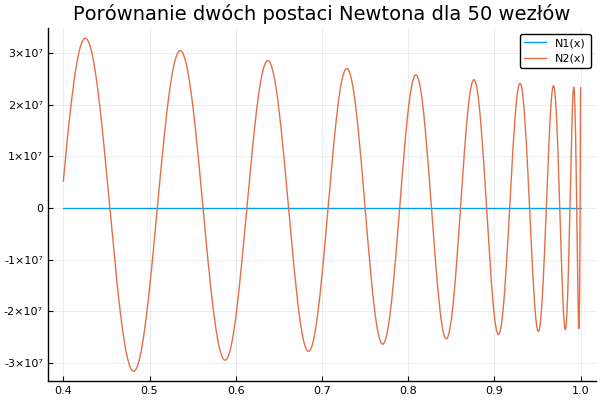

In [3]:
N1, N2 = cons_Newtons(50, genChebyshevNodes, f, Float32)
n1(x) = ev(N1, x)
n2(x) = ev(N2, x)
plot(n1 , 0.4, 1, label="N1(x)")
plot!(n2, 0.4, 1, label="N2(x)")
title!("Porównanie dwóch postaci Newtona dla 50 wezłów")

W testach używam funkcji 
```julia
function inter(f, x, typ, krotka=true)
    ...
    return (LD, L, LB, N)
end
 ```
 gdzie:\
 f - przybliżana funkja \
 x - punkty w których chcemy ją przybliżyć \
 krotka - jeśli ``` =true``` funkcja zwraca krotkę, w p.p. zwraca specjalną strukturę, której używam w ```prog.jl```

## Przykład interpolacji funcji $f(x) = \frac{1}{1 + 25x^2}$

W poniższych przykładach można zauważyć, jak każda z postaci wielomianu w inny sposób reaguje na kwestie numeryczne. O ile w przypadku wielomianu interpolacyjnego niskiego stopnia ma to małe znaczenie, to rozbieżności w przypadku wyższych stopni robią się znaczące.

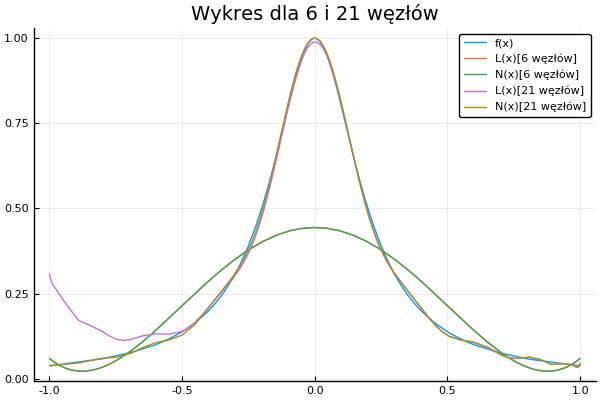

In [4]:
f(x) = 1 / (1 + 25*x*x)
_, L1,N1, _ = inter(f, genChebyshevNodes(6, 1, Float32), Float32)
plot(f, -1, 1, label="f(x)")
l1(x) = ev(L1, x)
n1(x) = ev(N1, x)
plot!(l1, -1, 1, label="L(x)[6 węzłów]")
plot!(n1, -1, 1, label="N(x)[6 węzłów]")

_, L2,N2, _ = inter(f, genChebyshevNodes(21, 1, Float32), Float32)
l2(x) = ev(L2, x)
n2(x) = ev(N2, x)
plot!(l2, -1, 1, label="L(x)[21 węzłów]")
plot!(n2, -1, 1, label="N(x)[21 węzłów]")
title!("Wykres dla 6 i 21 węzłów")

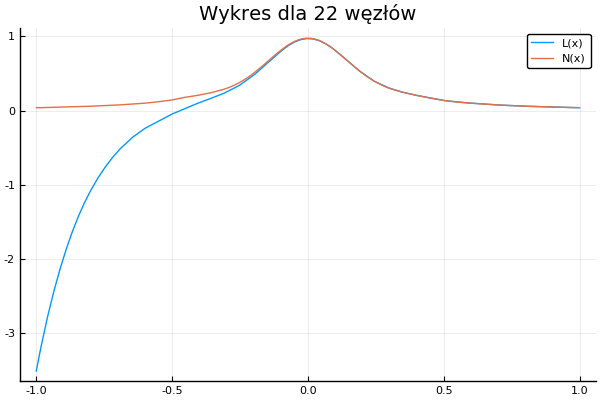

In [5]:
_, L3,N3, _ = inter(f, genChebyshevNodes(22, 1, Float32), Float32)
l3(x) = ev(L3, x)
n3(x) = ev(N3, x)
plot(l3, -1, 1, label="L(x)")
plot!(n3, -1, 1, label="N(x)")
title!("Wykres dla 22 węzłów")

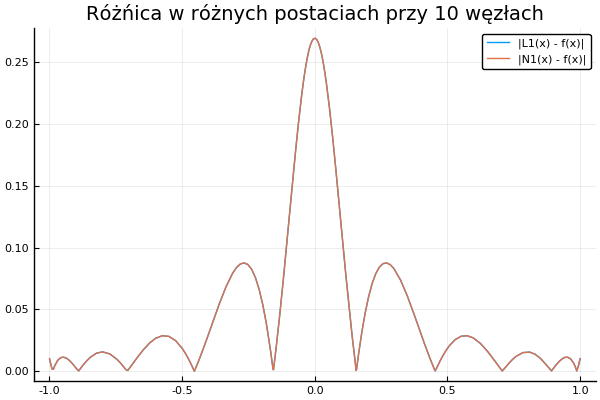

In [6]:
_, L1,N1, _ = inter(f, genChebyshevNodes(10, 1, Float32), Float32)
d11(x) = abs(ev(L1, x) - f(x))
d12(x) = abs(ev(N1, x) - f(x))
plot(d11, -1, 1, label="|L1(x) - f(x)|")
plot!(d12, -1, 1, label="|N1(x) - f(x)|")
title!("Różńica w różnych postaciach przy 10 węzłach")

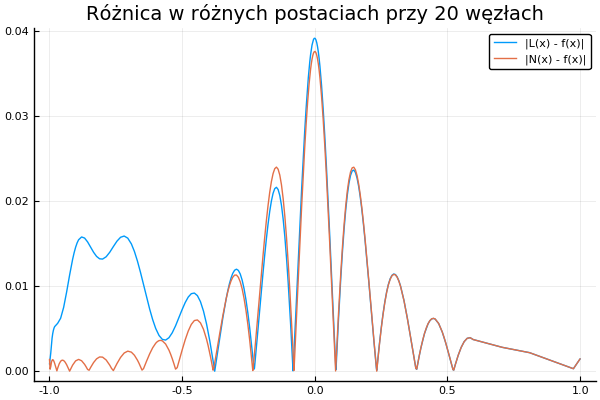

In [7]:
_, L2,N2, _ = inter(f, genChebyshevNodes(20, 1, Float32), Float32)
d21(x) = abs(ev(L2, x) - f(x))
d22(x) = abs(ev(N2, x) - f(x))
plot(d21, -1, 1, label="|L(x) - f(x)|")
plot!(d22, -1, 1, label="|N(x) - f(x)|")
title!("Różnica w różnych postaciach przy 20 węzłach")

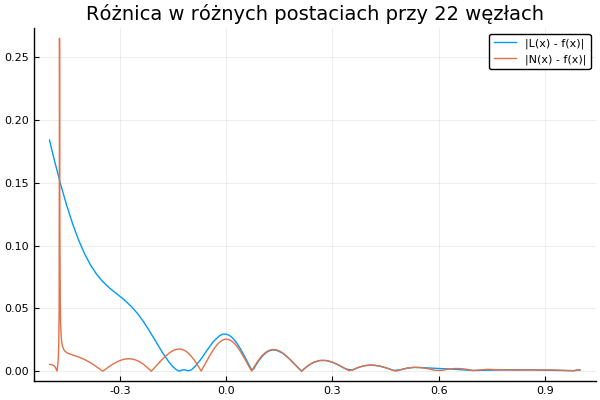

In [8]:
_, L3,N3, _ = inter(f, genChebyshevNodes(22, 1, Float32), Float32)
d31(x) = abs(ev(L3, x) - f(x))
d32(x) = abs(ev(N3, x) - f(x))
plot(d31, -0.5, 1, label="|L(x) - f(x)|")
plot!(d32, -0.5, 1, label="|N(x) - f(x)|")
title!("Różnica w różnych postaciach przy 22 węzłach")